## Vgg19 muti sz

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import os,shutil

# Fastai reloads
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Impost fastai
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
from fastai.callbacks import *
from fastai.imports import *
from fastai.callbacks.mem import PeakMemMetric

from pathlib import Path

from torchvision.models import *
from torch.nn import CrossEntropyLoss
import cv2
#import pretrainedmodels

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns

In [3]:
PATH=Path('data/')

## Create Data block (Try with 1/4 size)

In [4]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [5]:
img=open_image(PATH/'train_resized'/os.listdir(PATH/'train_resized')[1])

In [6]:
img.shape

torch.Size([3, 150, 210])

In [7]:
src_size=np.array(img.shape[1:]);src_size

array([150, 210])

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [9]:
data = (src.transform(tfms, size=src_size//4)
        .databunch(bs=256).normalize(imagenet_stats))        

In [10]:
data.classes

['1', '2', '3', '4', '5']

In [11]:
data

ImageDataBunch;

Train: LabelList (6252 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: EmptyLabelList
,,,,
Path: data

## Try with Vgg19

In [91]:
#f1 = partial(fbeta, thresh=0.2, beta = 1)

In [11]:
metrics_custom=[fbeta,accuracy_thresh]

In [13]:
learn=cnn_learner(data,models.vgg19_bn,metrics=metrics_custom)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


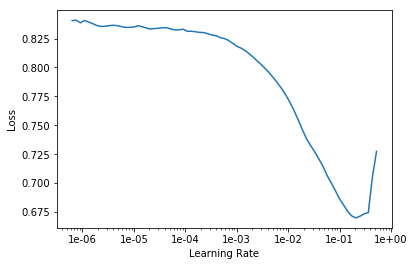

In [15]:
learn.recorder.plot()

In [16]:
lr=2e-2

In [17]:
learn.fit_one_cycle(15,slice(lr)).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

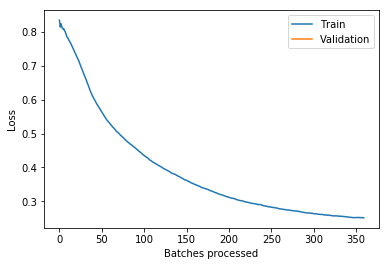

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.save('vgg19-5-imagenet-onefrth-stage-1-noval')

In [20]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


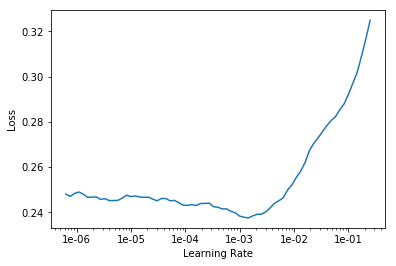

In [23]:
learn.recorder.plot()

In [24]:
lr=2e-4

In [25]:
learn.fit_one_cycle(15,slice(lr,3e-2)).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

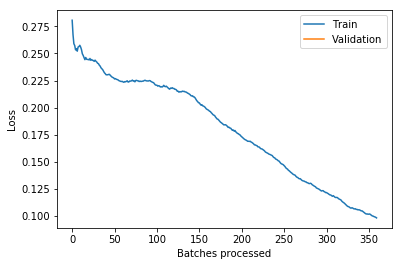

In [26]:
learn.recorder.plot_losses()

In [27]:
learn.save('vgg19-5-imagenet-onefrth-stage-2-noval')

In [28]:
learn.load('vgg19-5-imagenet-onefrth-stage-2-noval')

Learner(data=ImageDataBunch;

Train: LabelList (6252 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64,

## Pass 1/3rd size

In [29]:
data = (src.transform(tfms, size=src_size//3)
        .databunch(bs=256).normalize(imagenet_stats))  

In [30]:
learn.data=data

In [31]:
learn.freeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


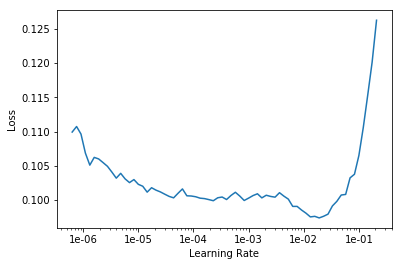

In [33]:
learn.recorder.plot()

In [34]:
lr=2e-3

In [35]:
learn.fit_one_cycle(15,max_lr=slice(lr)).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

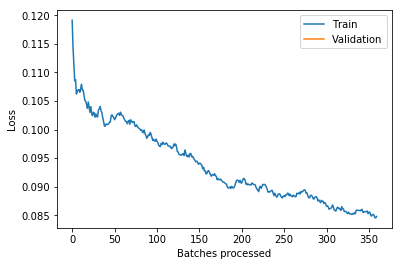

In [36]:
learn.recorder.plot_losses()

In [37]:
learn.save('vgg19-5-imagenet-onethrd-stage-3-noval')

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


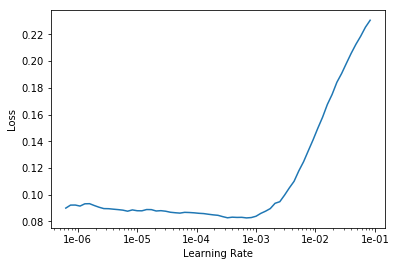

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lr=1e-4
learn.fit_one_cycle(10,max_lr=slice(lr,2e-3),wd=1e-3).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

In [41]:
learn.save('vgg19-5-imagenet-onethrd-stage-4-noval')

## Pass half size

In [42]:
data = (src.transform(tfms, size=src_size//2)
        .databunch(bs=128).normalize(imagenet_stats))

In [43]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


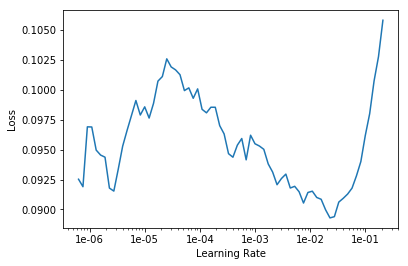

In [44]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [45]:
lr=2e-3
learn.fit_one_cycle(12,max_lr=slice(lr),wd=1e-4).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

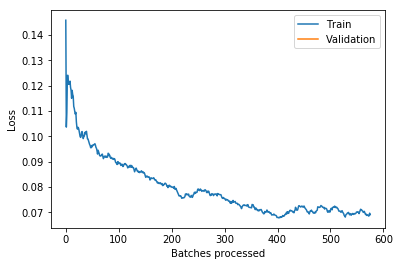

In [46]:
learn.recorder.plot_losses()

In [47]:
learn.save('vgg-5-imagenet-half-stage-5-noval')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


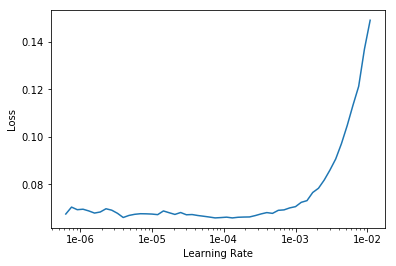

In [48]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [49]:
lr=2e-5
learn.fit_one_cycle(7,max_lr=slice(lr,2e-3)).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

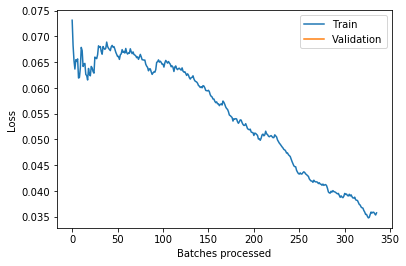

In [50]:
learn.recorder.plot_losses()

In [51]:
learn.save('vgg19-5-imagenet-half-stage-6-noval')

## Pass full size image

In [52]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=128).normalize(imagenet_stats))

In [53]:
learn.data=data

In [54]:
learn.data

ImageDataBunch;

Train: LabelList (6252 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


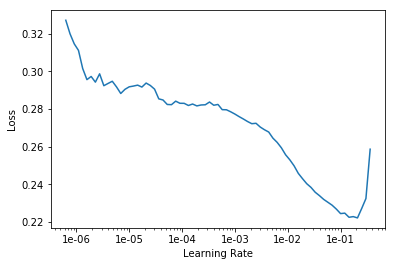

In [55]:
#learn.load('resnet-5-imagenet-half-stage-6')
learn.freeze()
learn.data=data
learn.lr_find()
learn.recorder.plot()

In [56]:
lr=1e-2
learn.fit_one_cycle(15,slice(lr),wd=1e-4).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

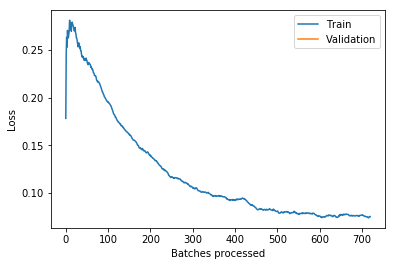

In [57]:
learn.recorder.plot_losses()

In [58]:
learn.save('vgg19-5-imagenet-full-stage-7-noval')

In [59]:
learn.load('vgg19-5-imagenet-full-stage-7-noval')

Learner(data=ImageDataBunch;

Train: LabelList (6252 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


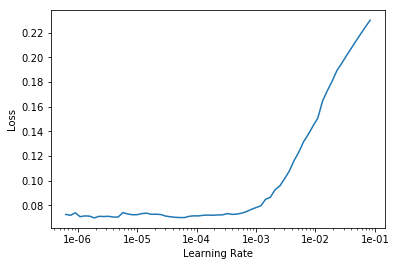

In [60]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [61]:
lr=3e-5
learn.fit_one_cycle(20,max_lr=slice(lr,1e-2),wd=1e-4).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

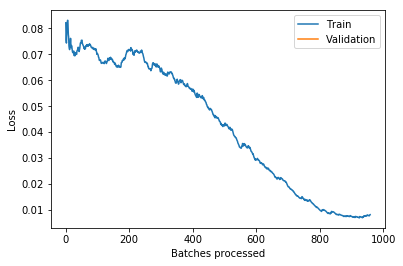

In [62]:
learn.recorder.plot_losses()

In [63]:
learn.save('vgg19-5-imagenet-full-stage-8-noval')

In [64]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)

In [56]:
test_pred_tta

(tensor([[9.9283e-01, 2.0347e-04, 9.6460e-04, 9.0035e-04, 5.3188e-04],
         [1.4024e-03, 1.9425e-04, 9.9864e-01, 3.3871e-04, 2.0669e-04],
         [5.7922e-01, 2.0019e-02, 5.9642e-04, 6.7006e-02, 2.8913e-01],
         ...,
         [9.3079e-02, 2.2776e-04, 8.4911e-01, 5.1968e-02, 1.7440e-03],
         [1.2892e-04, 9.9938e-01, 2.5478e-05, 1.7694e-04, 8.0086e-05],
         [9.8172e-01, 3.3297e-04, 1.0101e-04, 5.6791e-05, 1.7353e-02]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [65]:
preds = np.argmax(test_pred_tta[0], 1)
preds

tensor([0, 2, 4,  ..., 2, 1, 0])

In [66]:
a=array(preds)

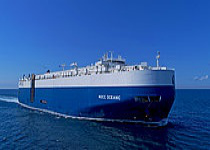

In [67]:
data.test_ds.x[1]

In [68]:
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]

In [69]:
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.head(10)

,image,category
0,2904735.jpg,1
1,2890616.jpg,3
2,2902677.jpg,5
3,2741468.jpg,4
4,2802610.jpg,5
5,1630950.jpg,4
6,2882184.jpg,3
7,2787793.jpg,2
8,2866032.jpg,1
9,2369442.jpg,2


In [75]:
len(submission)

2680

In [70]:
submission.to_csv(PATH/'submission_vgg19_multisz-noval.csv',index=False)

## Low confidence

In [155]:
data

ImageDataBunch;

Train: LabelList (6252 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [138]:
learn_cln = cnn_learner(data, models.vgg19_bn, metrics=metrics_custom)
learn_cln.load('vgg19-5-imagenet-full-stage-8-noval')

Learner(data=ImageDataBunch;

Train: LabelList (6252 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [161]:
learn_cln.data=data

In [173]:
len(data.train_ds)

6252

In [171]:
data.train_ds.x

ImageList (6252 items)
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
Path: data

In [177]:
learn_cln.predict(data.train_ds.x[0])

(MultiCategory 1,
 tensor([1., 0., 0., 0., 0.]),
 tensor([1.0000e+00, 1.2438e-07, 8.0754e-08, 6.4650e-08, 1.2492e-06]))

In [178]:
data.train_ds.y[0]

MultiCategory 1

In [188]:
log_preds=list()
#preds=list()
for i in range(0,len(data.train_ds)):
    _,_,log_pred=learn_cln.predict(data.train_ds.x[i])
    #preds.append(pred)
    log_preds.append(log_pred.numpy())

In [189]:
log_preds

[array([9.999970e-01, 1.243818e-07, 8.075374e-08, 6.465027e-08, 1.249182e-06], dtype=float32),
 array([9.979041e-01, 4.215205e-06, 1.170864e-05, 1.730853e-06, 2.155678e-03], dtype=float32),
 array([6.274313e-03, 9.872969e-01, 3.560998e-04, 2.160408e-03, 3.297520e-04], dtype=float32),
 array([2.909193e-06, 1.177863e-05, 9.999710e-01, 7.783027e-06, 5.574287e-06], dtype=float32),
 array([4.238977e-06, 9.999970e-01, 2.054062e-07, 5.871582e-08, 4.292801e-07], dtype=float32),
 array([9.889760e-04, 4.429484e-05, 2.798430e-05, 9.991806e-01, 1.710650e-04], dtype=float32),
 array([9.981338e-01, 7.812623e-05, 2.687412e-04, 5.216462e-04, 3.314404e-04], dtype=float32),
 array([6.734415e-01, 4.803255e-06, 7.248753e-06, 1.023540e-06, 4.239032e-01], dtype=float32),
 array([1.704129e-08, 2.234755e-07, 9.999996e-01, 3.225232e-08, 7.783257e-08], dtype=float32),
 array([9.999912e-01, 8.299348e-07, 8.761412e-07, 5.911367e-07, 1.767123e-06], dtype=float32),
 array([2.616760e-08, 1.603415e-07, 9.999999e-01, 

In [190]:
preds = np.argmax(log_preds, 1)+1
preds

array([1, 1, 2, 3, ..., 2, 5, 3, 1])

In [193]:
len(log_preds)

6252

In [196]:
conf = np.amax(log_preds, 1)

In [197]:
min(conf)

0.45792294

In [198]:
train_csv = pd.read_csv('data/train.csv');train_csv.head(2)

,image,category
0,2823080.jpg,1
1,2870024.jpg,1


In [199]:
submission = pd.DataFrame({'image': train_csv['image'], 'confidence': conf, 'pred': preds, 'category': train_csv['category']})

In [200]:
submission.head()

,image,confidence,pred,category
0,2823080.jpg,0.999997,1,1
1,2870024.jpg,0.997904,1,1
2,2662125.jpg,0.987297,2,2
3,2900420.jpg,0.999971,3,3
4,2804883.jpg,0.999997,2,2


In [222]:
df_sorted = submission.sort_values(by=['confidence'])
df_sorted.head(20)

,image,confidence,pred,category
334,2160815.jpg,0.457923,5,2
4326,2831345.jpg,0.472846,5,1
2154,2898495.jpg,0.523682,1,1
341,2876211.jpg,0.544852,5,1
2183,2872263.jpg,0.546522,4,2
936,2816481.jpg,0.589524,5,2
1107,1072012.jpg,0.632732,4,4
1094,2666067.jpg,0.635233,2,2
2464,2790267.jpg,0.646244,1,1
4836,2863890.jpg,0.660905,2,2


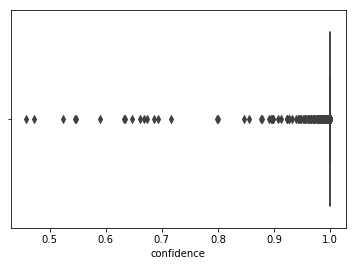

In [227]:
import seaborn as sns
sns.boxplot(df_sorted.confidence)

In [202]:
df_sorted.tail()

,image,confidence,pred,category
1901,2878411.jpg,1.0,2,2
2761,2720074.jpg,1.0,2,2
2759,1604225.jpg,1.0,4,4
1138,2863780.jpg,1.0,2,2
1877,2501490.jpg,1.0,4,4


In [233]:
df_lowest_conf = df_sorted.loc[(df_sorted['confidence'] < 0.85) | (df_sorted['confidence']>0.9)][df_sorted['category']!=df_sorted['pred']]

/anaconda/envs/fastai_v1/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [234]:
df_lowest_conf

,image,confidence,pred,category
334,2160815.jpg,0.457923,5,2
4326,2831345.jpg,0.472846,5,1
341,2876211.jpg,0.544852,5,1
2183,2872263.jpg,0.546522,4,2
936,2816481.jpg,0.589524,5,2
7,2843780.jpg,0.673441,1,5
278,2884323.jpg,0.685814,1,5
2706,2792375.jpg,0.800315,5,1
346,2866146.jpg,0.922293,1,5


In [235]:
len(df_lowest_conf)

9

In [237]:
df_lowest_conf.to_csv('low_confidence.csv',index=False)

In [238]:
new_train_df = train_csv[~train_csv['image'].isin(df_lowest_conf['image'])]

In [241]:
new_train_df.shape,train_csv.shape

((6243, 2), (6252, 2))

In [242]:
new_train_df.to_csv('train.csv',index=False)

## Train after cleaning

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [9]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=128).normalize(imagenet_stats))    

In [12]:
learn=cnn_learner(data,models.vgg19_bn,metrics=metrics_custom).load('vgg19-5-imagenet-full-stage-8-noval')

In [13]:
lr=3e-5

In [14]:
#del learn_cln, db
torch.cuda.empty_cache()

In [15]:
learn.fit_one_cycle(5,max_lr=slice(lr,1e-4),wd=1e-3).to_f16()

AttributeError: 'NoneType' object has no attribute 'to_f16'

In [16]:
learn.save('vgg19-5-imagenet-full-stage-8-noval-cleaned')

In [17]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_vgg19_multisz-noval-cleaned.csv',index=False)